#cumfreq - ajustar melhor modelo de distribuição

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

### Estados operacionais

In [100]:
GENERATOR = 1

In [101]:
df_event = pd.read_excel('../data/raw/EstadosOperativos.xlsx', sheet_name='BANCO', parse_dates=['Inicio', 'Fim'], usecols=[0,1,4,7,8,10,11,12,13,14,15,16,17,18])
df_event = df_event[df_event['Cód.UG'] == f'SC-ADOP-0UG{GENERATOR}']

#df_event = df_event[(df_event.Inicio >= df.index.min()) & (df_event.Fim < df.index.max())]

df_event['Breakdown'] = df_event['EstadoOperativo'].shift(-1).apply(lambda x: True if x == 'HDF' else False)

df_event = df_event.reset_index()

df_event.head()

/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


,index,Cód.UG,EstadoOperativo,Inicio,...,Justificativa religamento após 30min,Correção,Just.,Breakdown
0,54328,SC-ADOP-0UG1,HRD,2017-12-01 00:00:00,...,NaN,0,Preenchimento ok,False
1,54329,SC-ADOP-0UG1,HRD,2017-12-06 08:00:00,...,NaN,0,Preenchimento ok,False
2,54330,SC-ADOP-0UG1,HRD,2017-12-11 00:00:00,...,NaN,0,Preenchimento ok,False
3,54331,SC-ADOP-0UG1,HDP,2017-12-13 10:50:00,...,HDP,0,Preenchimento ok,False
4,54332,SC-ADOP-0UG1,HRD,2017-12-13 14:02:00,...,NaN,0,Preenchimento ok,False


In [102]:
# Check subsequent LIG states
display(df_event[(df_event['EstadoOperativo'] == 'LIG') & (df_event['EstadoOperativo'] == df_event['EstadoOperativo'].shift(-1))])

subseq_lig = df_event.loc[(df_event['EstadoOperativo'] == 'LIG') & (df_event['EstadoOperativo'] == df_event['EstadoOperativo'].shift(1)), 'Fim']

# Assign end to next subsequent LIG
df_event.loc[(df_event['EstadoOperativo'] == 'LIG') & (df_event['EstadoOperativo'] == df_event['EstadoOperativo'].shift(-1)), 'Fim'] = subseq_lig.values

# Drop last lig State
df_event = df_event.drop(subseq_lig.index)

,index,Cód.UG,EstadoOperativo,Inicio,...,Justificativa religamento após 30min,Correção,Just.,Breakdown
26,54354,SC-ADOP-0UG1,LIG,2017-12-23 09:16:00,...,NaN,0,Preenchimento ok,False
46,54374,SC-ADOP-0UG1,LIG,2018-01-30 20:50:00,...,NaN,0,Preenchimento ok,False
98,54426,SC-ADOP-0UG1,LIG,2018-03-29 14:35:00,...,NaN,0,Preenchimento ok,False
160,54488,SC-ADOP-0UG1,LIG,2018-06-30 11:49:00,...,NaN,0,Preenchimento ok,False
220,54548,SC-ADOP-0UG1,LIG,2018-09-27 14:55:00,...,NaN,0,Preenchimento ok,False


In [103]:
df = df_event[(df_event.EstadoOperativo == 'LIG')].copy()


df['Time'] = (df.Fim - df.Inicio).dt.seconds // 60

df = df[['Time', 'Breakdown']].astype(int)

df['BreakdownAcc'] = df.Breakdown.cumsum()

df = df.groupby('BreakdownAcc')['Time'].sum()

#df = df[df > 12]

#df = df.cumsum()

In [104]:
data = df.values.tolist()

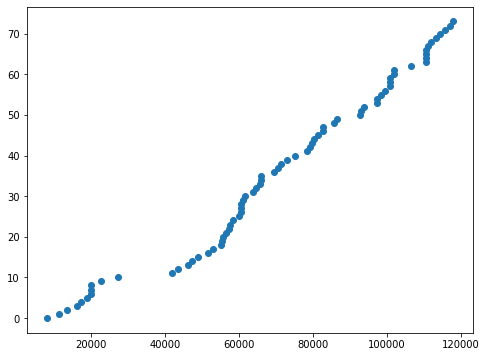

In [105]:
plt.figure(figsize=(8,6))

plt.scatter(df.cumsum().values, df.index, )

Results from ROCOF analysis:
Laplace test results: U = 2.824, z_crit = (-1.96,+1.96)
At 95% confidence level the ROCOF is WORSENING. Assume NHPP.
ROCOF assuming NHPP has parameters: Beta_hat = 1.533 , Lambda_hat = 1.239e-06


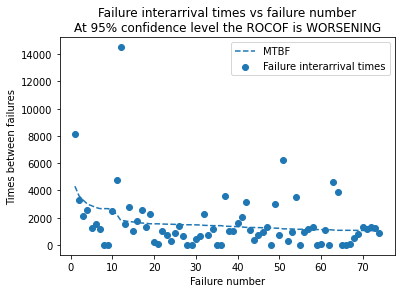

In [106]:
from reliability.Repairable_systems import ROCOF

ROCOF(times_between_failures=data)

Duane reliability growth model parameters:
Alpha: 0.51143
A: 0.83925
Demonstrated MTBF (cumulative): 164.12236
Demonstrated MTBF (instantaneous): 335.92166
Demonstrated failure intensity (cumulative): 0.006093
Demonstrated failure intensity (instantaneous): 0.0029769
Time to reach target MTBF: 2021766.53481



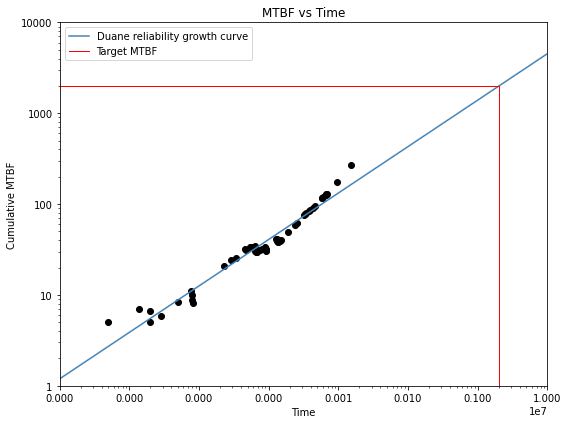

In [ ]:
from reliability.Repairable_systems import reliability_growth
from reliability.Datasets import system_growth
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
reliability_growth(times=df.values.tolist(),  model="Duane", target_MTBF=2000, log_scale=True)
plt.show()

Crow-AMSAA reliability growth model parameters:
Beta: 0.33642
Lambda: 2.19339
Growth rate: 0.66358
Demonstrated MTBF (cumulative): 271.85714
Demonstrated MTBF (instantaneous): 808.09723
Demonstrated failure intensity (cumulative): 0.0036784
Demonstrated failure intensity (instantaneous): 0.0012375
Time to reach target MTBF: 108382.65278



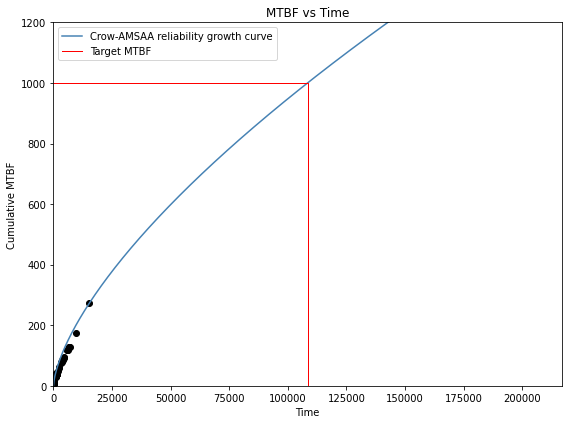

In [ ]:
from reliability.Repairable_systems import reliability_growth
from reliability.Datasets import system_growth
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
reliability_growth(times=df.values.tolist(), model="Crow-AMSAA", target_MTBF=1000)
plt.show()

Crow-AMSAA reliability growth model parameters:
Beta: 0.33642
Lambda: 2.19339
Growth rate: 0.66358
Demonstrated MTBF (cumulative): 271.85714
Demonstrated MTBF (instantaneous): 808.09723
Demonstrated failure intensity (cumulative): 0.0036784
Demonstrated failure intensity (instantaneous): 0.0012375
Time to reach target MTBF: 220070.72735

Duane reliability growth model parameters:
Alpha: 0.51143
A: 0.83925
Demonstrated MTBF (cumulative): 164.12236
Demonstrated MTBF (instantaneous): 335.92166
Demonstrated failure intensity (cumulative): 0.006093
Demonstrated failure intensity (instantaneous): 0.0029769
Time to reach target MTBF: 1306897.24994



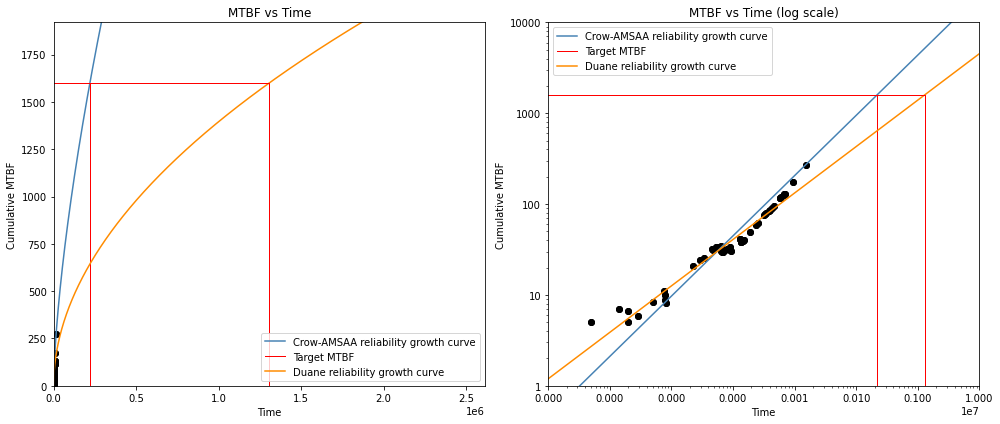

In [ ]:
from reliability.Repairable_systems import reliability_growth
from reliability.Datasets import automotive
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.subplot(121)
reliability_growth(times=df.values.tolist(), model="Crow-AMSAA", target_MTBF=1600)
reliability_growth(times=df.values.tolist(), model="Duane", target_MTBF=1600,color='darkorange')
plt.subplot(122)
reliability_growth(times=df.values.tolist(), model="Crow-AMSAA", target_MTBF=1600,print_results=False,log_scale=True)
reliability_growth(times=df.values.tolist(), model="Duane", target_MTBF=1600,color='darkorange',print_results=False,log_scale=True)
plt.title('MTBF vs Time (log scale)')
plt.show()

Results from Fit_Everything:
Analysis method: MLE
Failures / Right censored: 56/0 (0% right censored) 

   Distribution   Alpha     Beta  Gamma Alpha 1   Beta 1 Alpha 2      Beta 2 Proportion 1 DS      Mu   Sigma      Lambda  Log-likelihood    AICc     BIC       AD optimizer
     Weibull_CR                         1773.82 0.702458   15224 5.34159e+06                                                    -466.673  942.13 949.447 0.683546       TNC
       Gamma_3P 4197.12 0.511158 4.9999                                                                                         -474.356 955.173 960.788 0.852897       TNC
     Weibull_3P 1648.07 0.650804 4.9999                                                                                         -475.807 958.075  963.69 0.853662       TNC
     Weibull_2P  1753.6 0.719722                                                                                                -479.972  964.17 967.994 0.689369       TNC
       Gamma_2P 3539.94 0.607465    

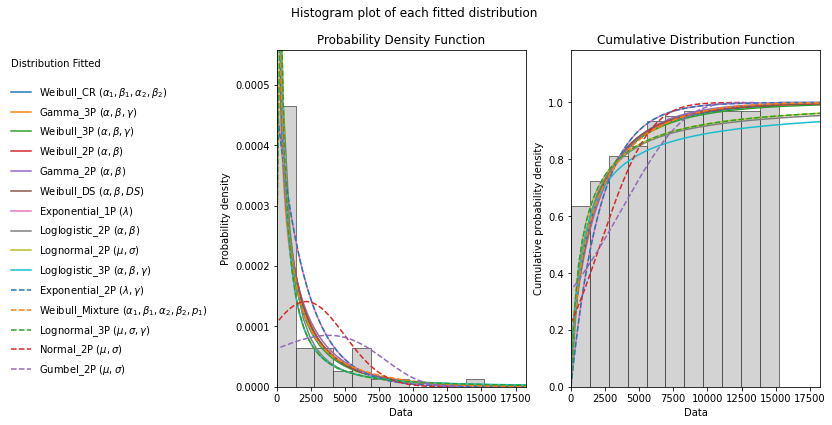

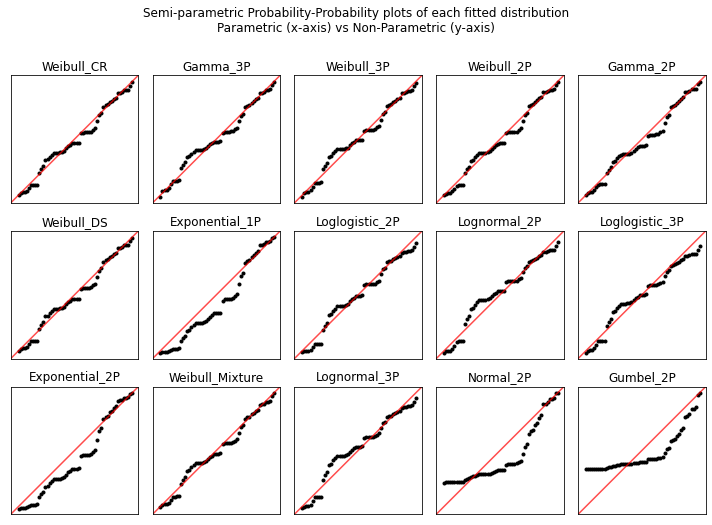

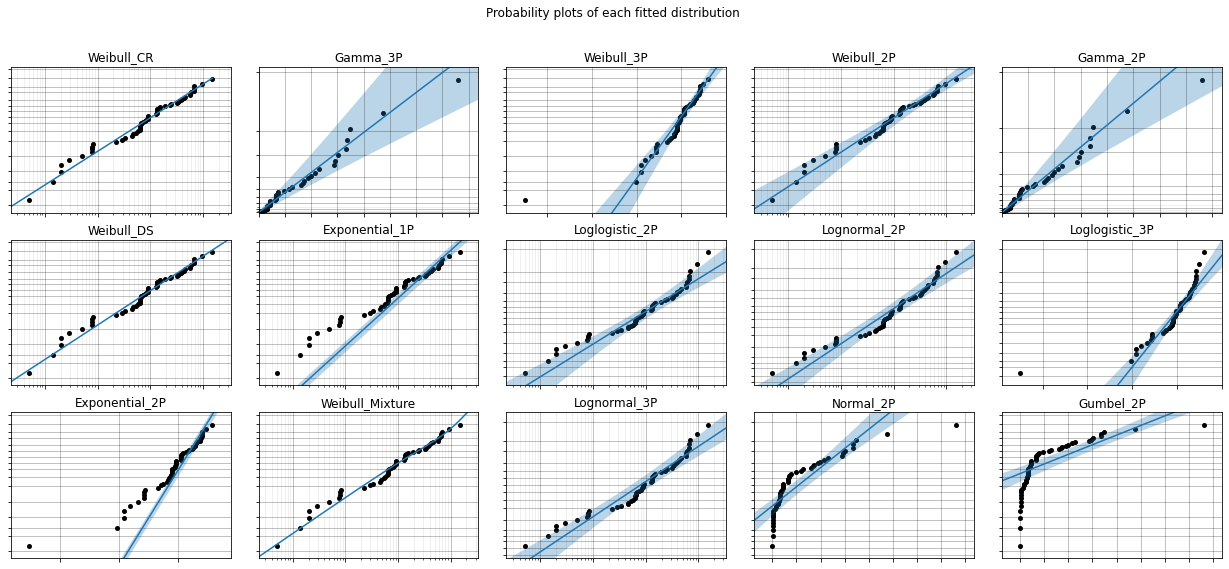

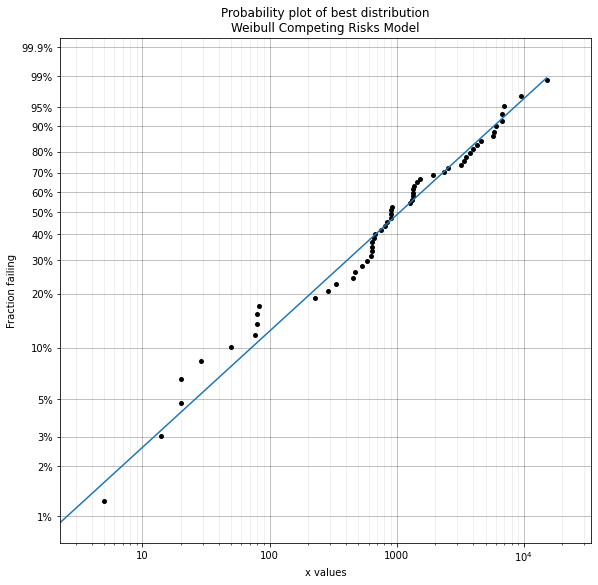

AttributeError: 'Competing_Risks_Model' object has no attribute 'parameters'

In [ ]:
from reliability.Fitters import Fit_Everything
results = Fit_Everything(failures=data)  # fit all the models
print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)


Results from Fit_Weibull_Mixture (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 56/0 (0% right censored) 

   Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
     Alpha 1         1058.87         1215.27   111.665   10040.9
      Beta 1        0.755216        0.185079  0.467164   1.22088
     Alpha 2         5884.89         4493.15   1317.77   26280.6
      Beta 2         1.48746         1.06041  0.367813   6.01542
Proportion 1        0.778834        0.468637 0.0167329   0.99863 

Goodness of fit    Value
 Log-likelihood -479.758
           AICc  970.716
            BIC  979.643
             AD 0.695746 



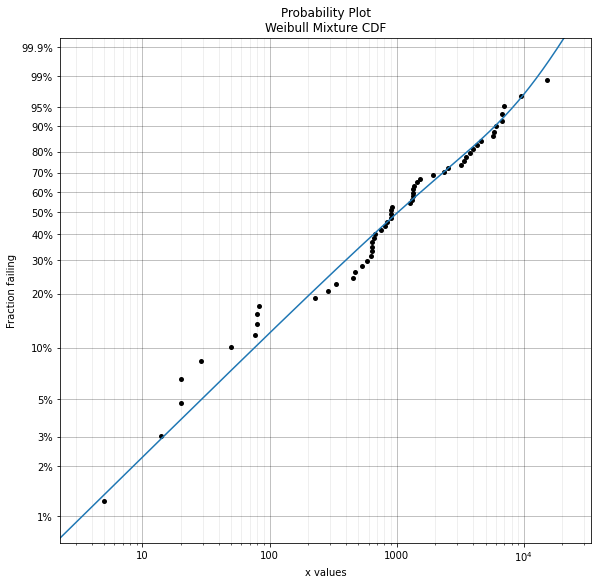

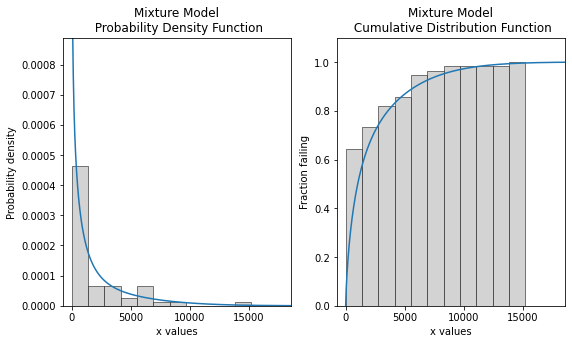

In [ ]:
from reliability.Fitters import Fit_Weibull_Mixture
from reliability.Other_functions import histogram


results = Fit_Weibull_Mixture(failures=data) #fit the mixture model

# this section is to visualise the histogram with PDF and CDF
# it is not part of the default output from the Fitter
plt.figure(figsize=(9, 5))
plt.subplot(121)
histogram(data)
results.distribution.PDF()
plt.subplot(122)
histogram(data, cumulative=True)
results.distribution.CDF()

plt.show()

In [ ]:
from reliability.Reliability_testing import sample_size_no_failures
sample_size_no_failures(reliability=0.95)


Results from sample_size_no_failures:
To achieve the desired reliability of 0.95 with a 95% lower confidence bound, the required sample size to test is 59 items.

This result is based on a specified weibull shape parameter of 1 and an equivalent test duration of 1 lifetime.
If there are any failures during this test, then the desired lower confidence bound will not be achieved.
If this occurs, use the function Reliability_testing.one_sample_proportion to determine the lower and upper bounds on reliability.


59